In [2]:
%matplotlib notebook
import pandas as pd
import mygrad as mg
import numpy as np
import re
from mynn.layers.dense import dense
from mynn.initializers.glorot_normal import glorot_normal
from mynn.optimizers.adam import Adam
from mygrad.nnet.losses import softmax_crossentropy
from gensim.models.keyedvectors import KeyedVectors
from noggin import create_plot

In [4]:
glove = KeyedVectors.load_word2vec_format("glove.6B.50d.txt.w2v", binary=False)

In [11]:

"""
Running this file trains an argument quality model and saves it to a file ArgumentQualityModel.npy.
Do not run this every time you want to test the model on your data.
Only run this once at the beginning to create the ArgumentQuality.npy file
    or to retrain the model.
This file should take a few minutes to run as it trains over 10 epochs on thousands of data items.
"""

# Loads glove, which contains english words and their embeddings into 50-dimensional vectors



def l2loss(pred, actual):  # L2 loss function (mean square distance)
    """

    Parameters
    ----------
    pred: Union[mygrad.Tensor, numpy.ndarray]
        A tensor or numpy array containing the model's predicted values
    actual: Union[mygrad.Tensor, numpy.ndarray]
        A tensor or numpy array containing the actual values

    Returns
    -------
    mg.Tensor
        A tensor containing the mean square distance between the prediction and actual values.
    """
    return mg.mean(mg.square(pred - actual))
class RNN:  # The RNN class, which passes the data through a gated recurrent unit to convert each sentence into an array
    def __init__(self, dim_input, dim_recurrent, dim_output):
        """ Initializes all layers needed for RNN

        Parameters
        ----------
        dim_input: int
            Dimensionality of data passed to RNN (C)

        dim_recurrent: int
            Dimensionality of hidden state in RNN (D)

        dim_output: int
            Dimensionality of output of RNN (K)
        """
        self.fc_x2h = dense(dim_input, dim_recurrent, weight_initializer=glorot_normal)
        self.fc_h2h = dense(
            dim_recurrent, dim_recurrent, weight_initializer=glorot_normal, bias=False
        )
        self.fc_h2y = dense(dim_recurrent, dim_output, weight_initializer=glorot_normal)
        self.Uz = mg.Tensor(
            np.random.randn(dim_input * dim_recurrent).reshape(dim_input, dim_recurrent)
        )
        self.Wz = mg.Tensor(
            np.random.randn(dim_recurrent * dim_recurrent).reshape(
                dim_recurrent, dim_recurrent
            )
        )
        self.bz = mg.Tensor(np.random.randn(dim_recurrent))
        self.Ur = mg.Tensor(
            np.random.randn(dim_input * dim_recurrent).reshape(dim_input, dim_recurrent)
        )
        self.Wr = mg.Tensor(
            np.random.randn(dim_recurrent * dim_recurrent).reshape(
                dim_recurrent, dim_recurrent
            )
        )
        self.br = mg.Tensor(np.random.randn(dim_recurrent))
        self.Uh = mg.Tensor(
            np.random.randn(dim_input * dim_recurrent).reshape(dim_input, dim_recurrent)
        )
        self.Wh = mg.Tensor(
            np.random.randn(dim_recurrent * dim_recurrent).reshape(
                dim_recurrent, dim_recurrent
            )
        )
        self.bh = mg.Tensor(np.random.randn(dim_recurrent))

    def __call__(self, x):
        """ Performs the full forward pass for the RNN.

        Note that we only care about the last y - the final classification scores for the full sequence

        Parameters
        ----------
        x: Union[numpy.ndarray, mygrad.Tensor], shape=(T, C)
            The one-hot encodings for the sequence

        Returns
        -------
        mygrad.Tensor, shape=(1, K)
            The final classification of the sequence
        """

        h = mg.nnet.gru(
            x,
            self.Uz,
            self.Wz,
            self.bz,
            self.Ur,
            self.Wr,
            self.br,
            self.Uh,
            self.Wh,
            self.bh,
        )
        return self.fc_h2y(h[-1])

    @property
    def parameters(self):
        """ A convenience function for getting all the parameters of our model.

        This can be accessed as an attribute, via `model.parameters`

        Returns
        -------
        Tuple[Tensor, ...]
            A tuple containing all of the learnable parameters for our model
        """
        return self.fc_x2h.parameters + self.fc_h2h.parameters + self.fc_h2y.parameters + (self.Uz, self.Wz, self.bz, self.Ur, self.Wr, self.br, self.Uh, self.Wh, self.bh)



[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
(6150, 78, 50) (6150,)


<IPython.core.display.Javascript object>


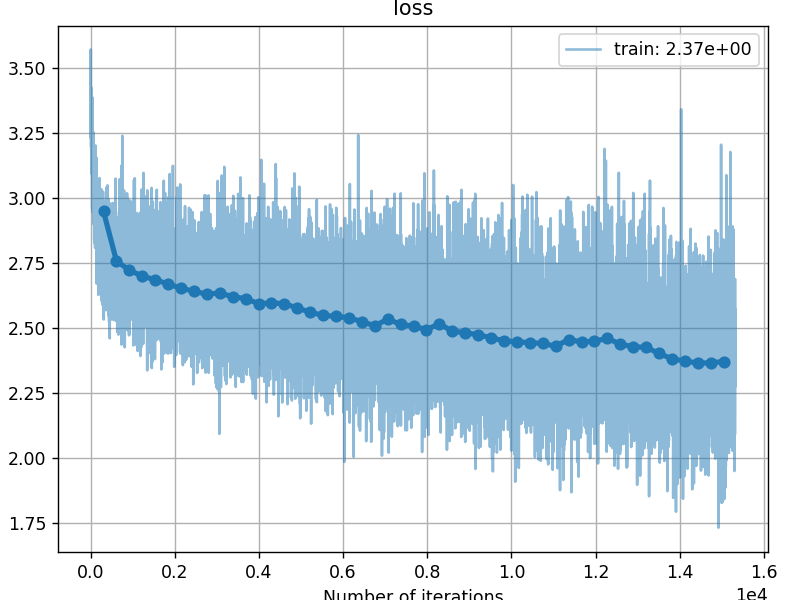

training epoch number  0
training epoch number  1
training epoch number  2
training epoch number  3
training epoch number  4
training epoch number  5
training epoch number  6
training epoch number  7
training epoch number  8
training epoch number  9
training epoch number  10
training epoch number  11
training epoch number  12
training epoch number  13
training epoch number  14
training epoch number  15
training epoch number  16
training epoch number  17
training epoch number  18
training epoch number  19
training epoch number  20
training epoch number  21
training epoch number  22
training epoch number  23
training epoch number  24
training epoch number  25
training epoch number  26
training epoch number  27
training epoch number  28
training epoch number  29
training epoch number  30
training epoch number  31
training epoch number  32
training epoch number  33
training epoch number  34
training epoch number  35
training epoch number  36
training epoch number  37
training epoch number 

In [12]:
def round20(n):
    return round(20*n)/20

def get_arr(n):
    z= np.zeros(21, dtype=int)
    z[int(20*n)] = int(1)
    return z
# Reads the csv file containing the train data
panda = pd.read_csv("train.csv")
nums = np.linspace(0,1,21)
print(nums)
# Creates arrays containing the evidence given that both stances are the same.
stance1 = np.array(panda["evidence_1_stance"])
stance2 = np.array(panda["evidence_2_stance"])
evidence_1 = [
    panda["evidence_1"][i] for i in range(len(stance1)) if stance1[i] == stance2[i]
]
evidence_2 = [
    panda["evidence_2"][i] for i in range(len(stance1)) if stance1[i] == stance2[i]
]

# Creates arrays containing the scores of the evidence given that both stances are the same.
y_train1 = [
    int(20*round20(panda["evidence_1_detection_score"][i]))
    for i in range(len(stance1))
    if stance1[i] == stance2[i]
]
y_train2 = [
    int(20*round20(panda["evidence_2_detection_score"][i]))
    for i in range(len(stance1))
    if stance1[i] == stance2[i]
]

# Takes in the text and converts it into an array of sentences.
x_train1 = []
indices_1 = []
for index, i in enumerate(evidence_1):

    i = i.lower().replace("[ref]", "")
    i = "".join(c for c in i if c.isdigit() or c.isalpha() or c == " ")
    i = re.sub(r" \W+", " ", i)
    i = i.split()
    row = []
    for word in i:
        try:
            row.append(glove[word])
        except:
            continue
    x_train1.append(row)

# Makes all sentence arrays the same shape by adding arrays of zeros to the end.
for i in x_train1:
    for j in range(len(i), 78):
        i.append(np.zeros(50))

# Repeats the process above for the 2nd half of the train data
x_train2 = []
indices_2 = []
for index, i in enumerate(evidence_2):

    i = i.lower().replace("[ref]", "")
    i = "".join(c for c in i if c.isdigit() or c.isalpha() or c == " ")
    i = re.sub(r" \W+", " ", i)
    i = i.split()
    row = []
    for word in i:
        try:
            row.append(glove[word])
        except:
            continue
    x_train2.append(row)
for i in x_train2:
    for j in range(len(i), 78):
        i.append(np.zeros(50))
        
#SECOND HALF
panda2 = pd.read_csv("test.csv")
nums = np.linspace(0,1,21)
print(nums)
# Creates arrays containing the evidence given that both stances are the same.
stance3 = np.array(panda2["evidence_1_stance"])
stance4 = np.array(panda2["evidence_2_stance"])
evidence_3 = [
    panda2["evidence_1"][i] for i in range(len(stance3)) if stance3[i] == stance4[i]
]
evidence_4 = [
    panda2["evidence_2"][i] for i in range(len(stance3)) if stance3[i] == stance4[i]
]

# Creates arrays containing the scores of the evidence given that both stances are the same.
y_train3 = [
    int(20*round20(panda2["evidence_1_detection_score"][i]))
    for i in range(len(stance3))
    if stance3[i] == stance4[i]
]
y_train4 = [
    int(20*round20(panda2["evidence_2_detection_score"][i]))
    for i in range(len(stance4))
    if stance3[i] == stance4[i]
]

# Takes in the text and converts it into an array of sentences.
x_train3 = []
indices_1 = []
for index, i in enumerate(evidence_3):

    i = i.lower().replace("[ref]", "")
    i = "".join(c for c in i if c.isdigit() or c.isalpha() or c == " ")
    i = re.sub(r" \W+", " ", i)
    i = i.split()
    row = []
    for word in i:
        try:
            row.append(glove[word])
        except:
            continue
    x_train3.append(row)

# Makes all sentence arrays the same shape by adding arrays of zeros to the end.
for i in x_train3:
    for j in range(len(i), 78):
        i.append(np.zeros(50))

# Repeats the process above for the 2nd half of the train data
x_train4 = []
indices_2 = []
for index, i in enumerate(evidence_4):

    i = i.lower().replace("[ref]", "")
    i = "".join(c for c in i if c.isdigit() or c.isalpha() or c == " ")
    i = re.sub(r" \W+", " ", i)
    i = i.split()
    row = []
    for word in i:
        try:
            row.append(glove[word])
        except:
            continue
    x_train4.append(row)
for i in x_train4:
    for j in range(len(i), 78):
        i.append(np.zeros(50))
# Concatenates the 2 sets of train data
xtrain = np.array(x_train1 + x_train2 + x_train3 + x_train4)

ytrain = np.array(y_train1 + y_train2 + y_train3 + y_train4)

print(xtrain.shape, ytrain.shape)
# Initializes the optimizer and the model with parameters.
dim_input = 50
dim_recurrent = 10
dim_output = 21
rnn = RNN(dim_input, dim_recurrent, dim_output)
optimizer = Adam(rnn.parameters)


plotter, fig, ax = create_plot(metrics=["loss"])




batch_size = 20

# Trains the model over 10 epochs.
for epoch_cnt in range(50):
    idxs = np.arange(len(xtrain))
    np.random.shuffle(idxs)
    print("training epoch number ", epoch_cnt)

    for batch_cnt in range(0, len(xtrain) // batch_size):
        batch_indices = idxs[batch_cnt * batch_size : (batch_cnt + 1) * batch_size]
        
        old = xtrain[batch_indices]
        batch = np.ascontiguousarray(np.swapaxes(old, 0, 1))
        prediction = rnn(batch)
        #print(prediction.shape)
        truth = ytrain[batch_indices]
        #print("pred: ", prediction)
        #print("truth: ", truth)
        loss = softmax_crossentropy(prediction, truth)

        loss.backward()

        optimizer.step()
        loss.null_gradients()

        plotter.set_train_batch({"loss": loss.item()}, batch_size=batch_size)
    plotter.set_train_epoch()


diff = 0
sum = 0

# Tests the model
for i in range(len(ytrain)):
    old = xtrain[i]
    w = np.ascontiguousarray(np.swapaxes(np.array(old).reshape(1, 78, 50), 0, 1))
    pred = rnn(w)
    true = ytrain[i]
    diff += mg.abs(pred - true)
    sum += true


i = 1
old = xtrain[i]

w = np.ascontiguousarray(np.swapaxes(np.array(old).reshape(1, 78, 50), 0, 1))
pred = rnn(w)
true = ytrain[i]

# Saves the model as "ArgumentQualityModel.npy"


In [13]:
#x = xtrain[i]
#a = glove["hello"]
#w = np.ascontiguousarray(np.swapaxes(np.array(x).reshape(1,78,50),0,1))
#print(np.argmax(rnn(w))/20, ytrain[i]/20)
sum = 0

for i in range(len(ytrain)):
    sum+=np.abs((np.argmax(rnn(np.ascontiguousarray(np.swapaxes(np.array(xtrain[i]).reshape(1,78,50),0,1))))/20)-(ytrain[i]/20))
print(sum/len(ytrain))

0.17326829268292537


In [14]:
i = input("What is your argument? ")
i = i.lower().replace("[ref]", "")
i = "".join(c for c in i if c.isdigit() or c.isalpha() or c == " ")
i = re.sub(r" \W+", " ", i)
i = i.split()
test = []
row = []
for word in i:
    try:
        row.append(glove[word])
    except:
        continue
test.append(row)
for i in test:
    for j in range(len(i), 78):
        i.append(np.zeros(50))
w = np.ascontiguousarray(np.swapaxes(np.array(test).reshape(1,78,50),0,1))
print(np.argmax(rnn(w))/20)


What is your argument? orange man
0.75


In [ ]:
np.save("ArgumentQualityModel.npy", rnn.parameters)

In [ ]:
j = np.load("ArgumentQualityModel.npy")

In [ ]:
k = RNN(50, 10, 21)
k.fc_x2h.weight, k.fc_x2h.bias, k.fc_h2h.weight, k.fc_h2y.weight, k.fc_h2y.bias, k.Uz, k.Wz, k.bz, k.Ur, k.Wr, k.br, k.Uh, k.Wh, k.bh = (
    j[0],
    j[1],
    j[2],
    j[3],
    j[4],
    j[5],
    j[6],
    j[7],
    j[8],
    j[9],
    j[10],
    j[11],
    j[12],
    j[13],
)

i = input("What is your argument? ")
i = i.lower().replace("[ref]", "")
i = "".join(c for c in i if c.isdigit() or c.isalpha() or c == " ")
i = re.sub(r" \W+", " ", i)
i = i.split()
test = []
row = []
for word in i:
    try:
        row.append(glove[word])
    except:
        continue
test.append(row)
for i in test:
    for j in range(len(i), 78):
        i.append(np.zeros(50))
w = np.ascontiguousarray(np.swapaxes(np.array(test).reshape(1,78,50),0,1))
print(np.argmax(k(w))/20)